In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation,rc,cm
from IPython.display import HTML
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error


In [33]:
class SN:
    
    def __init__(self,w_init,b_init,algo):
        self.w=w_init
        self.b=b_init
        self.algo=algo
        self.e_h = []
        self.w_h = []
        self.b_h = []
        
    def sigmoid(self,x,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        return 1.0/(1.0 + np.exp(-(w*x+b)))
    
    def error(self,X,Y,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        error= 0
        for x,y in zip(X,Y):
            error += 0.5 * (self.sigmoid(x,w,b) - y) ** 2
        return error
    
    def grad_w(self,x,y,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        y_pred = self.sigmoid(x,w,b)
        return (y_pred -y) * y_pred*(1-y_pred) * x
    
    def grad_b(self,x,y,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        y_pred = self.sigmoid(x,w,b)
        return (y_pred -y) * y_pred*(1-y_pred)
    
    def predict(self,X,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        Y_pred = []
        for x in X:
            y_pred=self.sigmoid(w,x,b)
            Y_pred.append(y_pred)
        return np.array(Y_pred)
    
    def fit(self,X,Y,epoch=100,display_loss=True,eta = 0.01, gamma=0.9,
            mini_batch_size=4,eps=1e-8,beta=0.9,beta1=0.9,beta2=0.9):
        
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.X = X
        self.Y = Y
        
        if display_loss:
            loss = {}
            
        if self.algo == "GD":
            for i in tqdm_notebook(range(epoch),unit="epoch"):
                db,dw=0,0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                m=X.shape[0]
                self.b -= eta * db/m
                self.w -= eta * dw/m
                self.append_log()
                
                if display_loss:
                    y_pred=self.predict(X)
                    loss[i] = mean_squared_error(y_pred,Y)
                
            if display_loss:
                plt.plot(loss.values())
                plt.xlabel("epoch")
                plt.ylabel("mse")
                plt.show()
                
        elif self.algo == "minibatch":
            for i in tqdm_notebook(range(epoch),unit="epoch"):
                db,dw=0,0
                points_seen=0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                    points_seen +=1
                    if points_seen % mini_batch_size == 0:
                        m=X.shape[0]
                        self.b -= eta * db/m
                        self.w -= eta * dw/m
                        self.append_log()
                
                        if display_loss:
                            y_pred=self.predict(X)
                            loss[i] = mean_squared_error(y_pred,Y)
                
            if display_loss:
                plt.plot(loss.values())
                plt.xlabel("epoch")
                plt.ylabel("mse")
                plt.show()
                
        elif self.algo == "momentum":
            v_b,v_w=0,0
            for i in tqdm_notebook(range(epoch),unit="epoch"):
                db,dw=0,0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                m=X.shape[0]
                v_b = gamma * v_b + eta *db
                v_w = gamma * v_w + eta *dw
                self.b -= v_b/m
                self.w -= v_w/m
                self.append_log()
                
                if display_loss:
                    y_pred=self.predict(X)
                    loss[i] = mean_squared_error(y_pred,Y)
                
            if display_loss:
                plt.plot(loss.values())
                plt.xlabel("epoch")
                plt.ylabel("mse")
                plt.show()
                
        elif self.algo == "NAG":
            v_b,v_w=0,0
            for i in tqdm_notebook(range(epoch),unit="epoch"):
                db,dw=0,0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x,y,self.w-v_w,self.b-v_b)
                    db += self.grad_b(x,y,self.w-v_w,self.b-v_b)
                m=X.shape[0]
                v_b += eta *db
                v_w += eta *dw
                self.b -= v_b/m
                self.w -= v_w/m
                self.append_log()
                
                if display_loss:
                    y_pred=self.predict(X)
                    loss[i] = mean_squared_error(y_pred,Y)
                
            if display_loss:
                plt.plot(loss.values())
                plt.xlabel("epoch")
                plt.ylabel("mse")
                plt.show()
                
        elif self.algo == "AdaGrad":
            v_b,v_w=0,0
            for i in tqdm_notebook(range(epoch),unit="epoch"):
                db,dw=0,0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                m=X.shape[0]
                v_b += db **2
                v_w += dw **2
                self.b -= (eta/np.sqrt(v_b) + eps)*db /m
                self.w -= (eta/np.sqrt(v_w) + eps)*dw /m
                self.append_log()
                
                if display_loss:
                    y_pred=self.predict(X)
                    loss[i] = mean_squared_error(y_pred,Y)
                
            if display_loss:
                plt.plot(loss.values())
                plt.xlabel("epoch")
                plt.ylabel("mse")
                plt.show()
                
        elif self.algo == "RMSprop":
            v_b,v_w=0,0
            for i in tqdm_notebook(range(epoch),unit="epoch"):
                db,dw=0,0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                m=X.shape[0]
                v_b = beta * v_b + (1-beta)*db **2
                v_w = beta * v_w + (1-beta)*dw **2
                self.b -= (eta/np.sqrt(v_b) + eps)*db /m
                self.w -= (eta/np.sqrt(v_w) + eps)*dw /m
                self.append_log()
                
                if display_loss:
                    y_pred=self.predict(X)
                    loss[i] = mean_squared_error(y_pred,Y)
                
            if display_loss:
                plt.plot(loss.values())
                plt.xlabel("epoch")
                plt.ylabel("mse")
                plt.show()
                
        elif self.algo == "Adam":
            v_b,v_w=0,0
            m_b,m_w=0,0
            num_updates=0
            for i in tqdm_notebook(range(epoch),unit="epoch"):
                db,dw=0,0
                for x,y in zip(X,Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                    num_updates +=1
                    m_b = (beta1 * v_b + (1-beta1)*db) /(1 - np.power(beta1, num_updates))
                    m_w = (beta1 * v_w + (1-beta1)*dw) /(1 - np.power(beta1, num_updates)) 
                    v_b = (beta2 * v_b + (1-beta2)*db **2) /(1 - np.power(beta2, num_updates))
                    v_w = (beta2 * v_w + (1-beta2)*dw **2) /(1 - np.power(beta2, num_updates))
                    self.b -= (eta/np.sqrt(v_b) + eps)*m_b
                    self.w -= (eta/np.sqrt(v_w) + eps)*m_w
                    self.append_log()
                
                    if display_loss:
                        y_pred=self.predict(X)
                        loss[i] = mean_squared_error(y_pred,Y)
                
            if display_loss:
                plt.plot(loss.values())
                plt.xlabel("epoch")
                plt.ylabel("mse")
                plt.show()
                
    def append_log(self):
        self.w_h.append(self.w)
        self.b_h.append(self.b)
        self.e_h.append(self.error(self.X,self.Y))
                
        
                
        
                

In [23]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])

algo = 'GD'

w_init = -6
b_init = 4.0

w_min = -7
w_max = 5

b_min = -7
b_max = 5

epochs = 500
gamma = 0.9
eta = 0.5
eps = 1e-8

animation_frames = 20

plot_2d = True
plot_3d = False

# For GD Algorithm

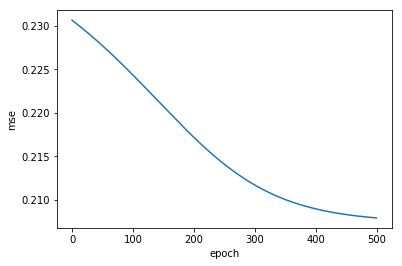

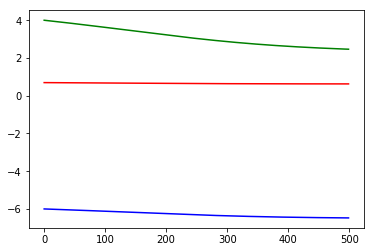

In [24]:
sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epoch=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()

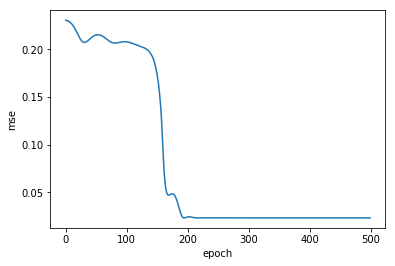

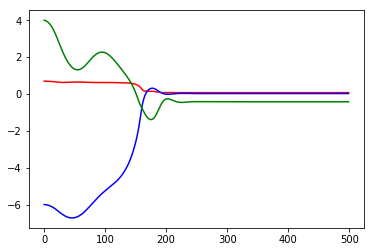

In [26]:
sn = SN(w_init, b_init, "NAG")
sn.fit(X, Y, epoch=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()

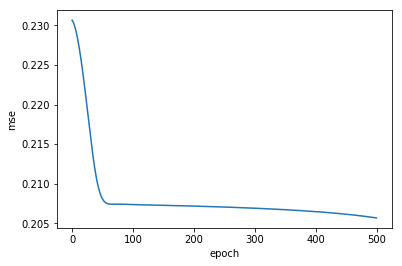

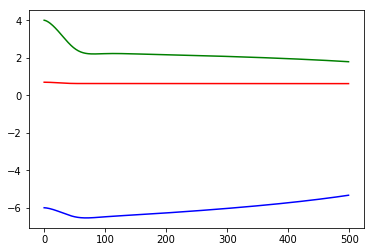

In [27]:
sn = SN(w_init, b_init, "momentum")
sn.fit(X, Y, epoch=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()

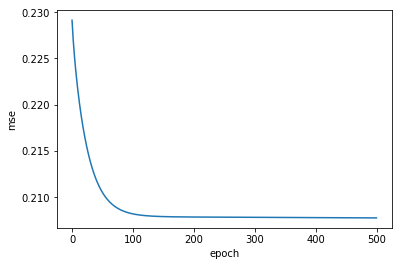

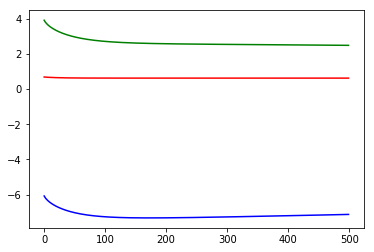

In [29]:
sn = SN(w_init, b_init, "AdaGrad")
sn.fit(X, Y, epoch=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()

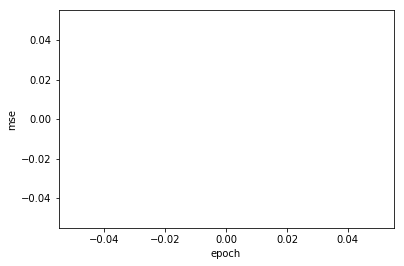

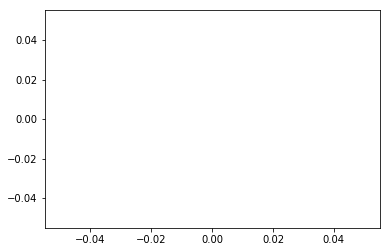

In [30]:
sn = SN(w_init, b_init, "minibatch")
sn.fit(X, Y, epoch=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()

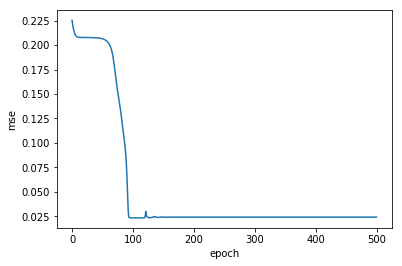

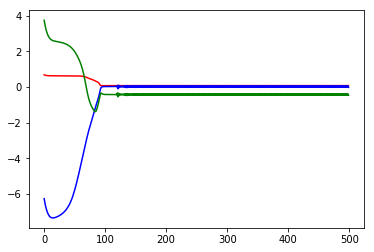

In [31]:
sn = SN(w_init, b_init, "RMSprop")
sn.fit(X, Y, epoch=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()

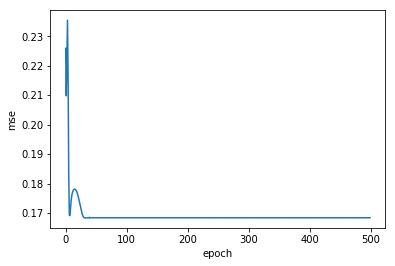

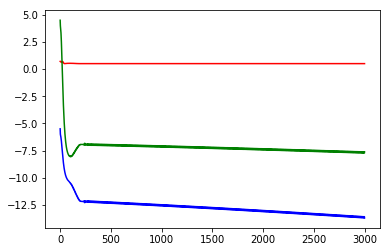

In [34]:
sn = SN(w_init, b_init, "Adam")
sn.fit(X, Y, epoch=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()